In [1]:
import pandas as pd
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt

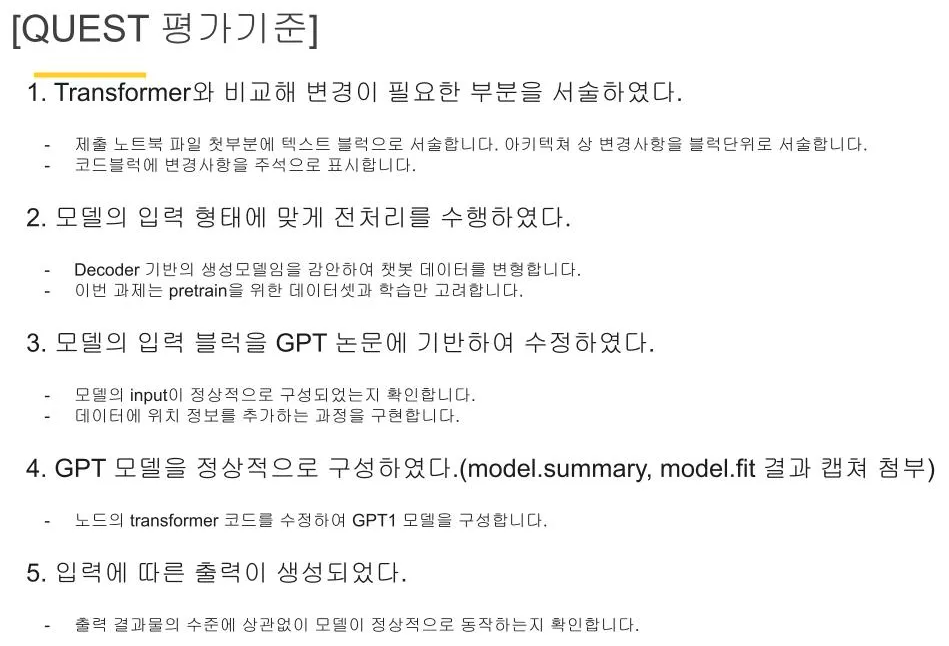

**루브릭**  
*아래의 기준을 바탕으로 프로젝트를 평가합니다.*

| 평가문항                                        | 상세기준                                        |
| :-------------------------------------------- | :------------------------------------------- |
| 1. Transformer와 비교해 변경이 필요한 부분을 서술했다. | - 제출 노트북 파일 첫 부분에 텍스트 블럭으로 서술. 아키텍처 상 변경 사항 서술.<br>- 코드 변경 사항 주석으로 표시.
| 2. 모델의 입력 형태에 맞게 전처리를 수행했다.           |                                               |
| 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정했다.     |                                               |
| 4. GPT 모델을 정상적으로 구성했다.                  |                                               |
| 5. 입력에 따른 출력을 생성했다.                     |                                               |

# 0. 준비
- [X] 필요 변경 사항 서술
- [X] 전처리 수행
- [X] 입력 블록 수정
- [ ] GPT 모델 정상 구성
- [ ] 출력 생성

## 트랜스포머 vs. GPT
---
|                    | 트랜스포머     |     GPT      |
|------------------:|:-----------:|:------------:|
| **구조**              | 인코더 & 디코더 | only 디코더   |
| **토큰 위치 정보 기록 방식** | 포지셔널 인코딩 | 포지셔널 임베딩 |

![Transformer structure](https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Transformer%2C_full_architecture.png/973px-Transformer%2C_full_architecture.png)![GPT structure](https://upload.wikimedia.org/wikipedia/commons/9/91/Full_GPT_architecture.png)


## 필요 변경 사항
---

- GPT 모델은 트랜스포머에서 인코더 부분을 제외하고 디코더 부분만 사용한다.
  - 인코더 제거
  - 인코더로부터 디코더가 받는 연결 부위를 제거
    - 인코더-디코더 어텐션
- GPT 모델은 위치 정보를 인코딩이 아닌 임베딩으로 처리한다.

# 1. 진행

## 1.1 데이터 수집하기
---
사용 데이터셋 출처: https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

> 챗봇 트레이닝용 문답 페어 11,876개  
> 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

## Step 2. 데이터 전처리하기
---

In [2]:
df = pd.read_csv('./data/ChatbotData.csv')

In [3]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(df['Q'])
print(MAX_SAMPLES)

11823


In [5]:
df['label'].value_counts()  # 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2

0    5290
1    3570
2    2963
Name: label, dtype: int64

위에서 출력한 피처가 흥미롭기는 하지만 본 프로젝트에서는 사용하지 않을 내용임에 따라 해당 속성을 제거한다.

In [6]:
df.drop('label', axis=1, inplace=True)
df

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


데이터셋을 살펴보면 전처리가 필요한 부분들을 발견할 수 있다. 아래는 대표적인 몇 가지 예시이다.

In [7]:
found_edge_cases_idx = [3556, 8818, 8819]

In [8]:
df.loc[found_edge_cases_idx, ['Q', 'A']]  # iloc 대신 loc 사용 (라벨과 인덱스 동일)

,Q,A
3556,울적하다,울적.... 우울할땐.... 울면
8818,흐음이거고민인데여;;,무슨 고민인지 말해보세요.
8819,흐잌~~ 불금이닷~~ㅠㅠ,퐈이야


In [9]:
# 전처리 함수
def preprocess_sentence(sentence):
    
    sentence = sentence.strip() # 입력받은 sentence의 양쪽 공백을 제거
 
    sentence = re.sub(r"([.!?;~])+", r"\1", sentence)   # 연속된 구두점들을 하나의 구두점으로 변환
    sentence = re.sub(r"([?.!,;~])", r" \1 ", sentence) # 단어와 구두점 사이의 거리 추가 (토커나이저가 공백을 기준으로 단어를 분리하기에, 단어와 구두점이 붙어있음에 따른 의미 손실을 방지)
    sentence = re.sub(r'[" "]+', " ", sentence)         # 연속된 공백을 하나의 공백으로 축소
    
    # (a-z, A-Z, ".", "?", "!", ",", ";", "~")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣0-9a-zA-Z.?!,;~]+", " ", sentence)
    sentence = sentence.strip()  # 새로 추가됐을 수 있는 문장 양쪽의 공백을 제거
    return sentence

In [10]:
processed_df = df.applymap(preprocess_sentence)
processed_df

,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,PPL 심하네,눈살이 찌푸려지죠 .
...,...,...
11818,훔쳐보는 것도 눈치 보임 .,티가 나니까 눈치가 보이는 거죠 !
11819,훔쳐보는 것도 눈치 보임 .,훔쳐보는 거 티나나봐요 .
11820,흑기사 해주는 짝남 .,설렜겠어요 .
11821,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요 .


In [11]:
# 전처리 후의 모습
processed_df.loc[found_edge_cases_idx, ['Q', 'A']]

,Q,A
3556,울적하다,울적 . 우울할땐 . 울면
8818,흐음이거고민인데여 ;,무슨 고민인지 말해보세요 .
8819,흐잌 ~ 불금이닷 ~,퐈이야


In [12]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = processed_df['Q'], processed_df['A']
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [13]:
len(processed_df)

11823

In [14]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Step 3. SubwordTextEncoder 사용하기
---

In [15]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers,
                                                                      target_vocab_size=2**13)

In [16]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [17]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8352]
END_TOKEN의 번호 : [8353]


In [18]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8354


In [19]:
# 22번째 샘플에 대해서 정수 인코딩 작업을 수행 (임의의 예시)
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 22번째 질문 샘플: {}'.format(tokenizer.encode(questions[22])))
print('정수 인코딩 후의 22번째 답변 샘플: {}'.format(tokenizer.encode(answers[22])))

정수 인코딩 후의 22번째 질문 샘플: [397, 802, 37, 402, 2]
정수 인코딩 후의 22번째 답변 샘플: [397, 802, 952, 6631, 12, 5120, 7765, 1106, 7956, 348, 5645, 39, 1]


In [20]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8354
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기
---

### 4.1 Positional Encoding

In [24]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

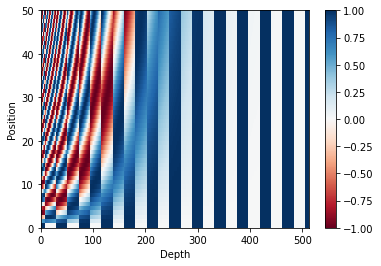

In [25]:
sample_pos_encoding = PositionalEncoding(50, 512) # [[YOUR CODE]]

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 4.2 Attention

In [26]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # [[YOUR CODE]]
    key = self.key_dense(key)        # [[YOUR CODE]]
    value = self.value_dense(value)  # [[YOUR CODE]]

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # [[YOUR CODE]]
    key = self.split_heads(key, batch_size)      # [[YOUR CODE]]
    value = self.split_heads(value, batch_size)  # [[YOUR CODE]]

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [28]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [29]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [30]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [31]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [32]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 4.3 Encoder

In [33]:
# # 인코더 하나의 레이어를 함수로 구현.
# # 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
# def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
#   inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

#   # 패딩 마스크 사용
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
#   attention = MultiHeadAttention(
#       d_model, num_heads, name="attention")({
#           'query': inputs,
#           'key': inputs,
#           'value': inputs,
#           'mask': padding_mask
#       })

#   # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
#   attention = tf.keras.layers.Dropout(rate=dropout)(attention)
#   attention = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(inputs + attention)

#   # 두 번째 서브 레이어 : 2개의 완전연결층
#   outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
#   outputs = tf.keras.layers.Dense(units=d_model)(outputs)

#   # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
#   outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#   outputs = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention + outputs)

#   return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [34]:
# def encoder(vocab_size,
#             num_layers,
#             units,
#             d_model,
#             num_heads,
#             dropout,
#             name="encoder"):
#   inputs = tf.keras.Input(shape=(None,), name="inputs")

#   # 패딩 마스크 사용
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   # 임베딩 레이어
#   embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#   embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

#   # 포지셔널 인코딩
#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

#   outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#   # num_layers만큼 쌓아올린 인코더의 층.
#   for i in range(num_layers):
#     outputs = encoder_layer(
#         units=units,
#         d_model=d_model,
#         num_heads=num_heads,
#         dropout=dropout,
#         name="encoder_layer_{}".format(i),
#     )([outputs, padding_mask])

#   return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 4.4 Decoder

In [35]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def transformer_block(units, d_model, num_heads, dropout, name="transformer_block"):  # -- 이름 변경
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")  # -- 제거
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

# -- 인코더-디코더 어텐션 제거
#   # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
#   attention2 = MultiHeadAttention(
#       d_model, num_heads, name="attention_2")(inputs={
#           'query': attention1,
#         #   'key': enc_outputs,     # -- 제거
#         #   'value': enc_outputs,   # -- 제거
#           'mask': padding_mask
#       })
#
#   # 마스크드 멀티 헤드 어텐션의 결과는
#   # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
#   attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
#   attention2 = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1) # -- attention 변경
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1) # -- attention 변경

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask],  # -- `enc_outputs` 제거
      outputs=outputs,
      name=name)

In [36]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')  # -- 제거
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = transformer_block(  # -- 'decoder_layer' -> 'transformer_block'
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='transformer_block_{}'.format(i),  # -- 이름 변경
    )(inputs=[outputs, look_ahead_mask, padding_mask])  # -- `enc_outputs` 제거

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask],  # -- `enc_outputs` 제거
      outputs=outputs,
      name=name)

### 4.5 Combine to 'Transformer' & Train

In [37]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

#   # 인코더
#   enc_outputs = encoder(
#       vocab_size=vocab_size,
#       num_layers=num_layers,
#       units=units,
#       d_model=d_model,
#       num_heads=num_heads,
#       dropout=dropout,
#   )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, look_ahead_mask, dec_padding_mask])  # -- `enc_outputs` 제거
  
  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [38]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3192832     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [39]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

아래는 모델이 학습을 진행함에 따른 학습률 변화의 시각화이다.

Text(0.5, 0, 'Train Step')

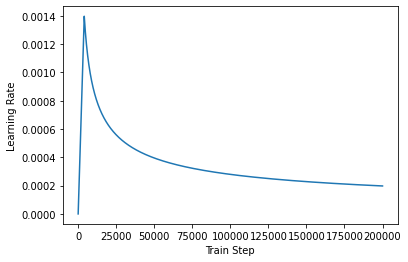

In [41]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [42]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [43]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 29s 52ms/step - loss: 1.4548 - accuracy: 0.0307
Epoch 2/30
185/185 [==============================] - 10s 52ms/step - loss: 1.1822 - accuracy: 0.0494
Epoch 3/30
185/185 [==============================] - 10s 52ms/step - loss: 1.0086 - accuracy: 0.0506
Epoch 4/30
185/185 [==============================] - 10s 52ms/step - loss: 0.9306 - accuracy: 0.0544
Epoch 5/30
185/185 [==============================] - 10s 53ms/step - loss: 0.8701 - accuracy: 0.0578
Epoch 6/30
185/185 [==============================] - 10s 53ms/step - loss: 0.8092 - accuracy: 0.0621
Epoch 7/30
185/185 [==============================] - 10s 53ms/step - loss: 0.7428 - accuracy: 0.0680
Epoch 8/30
185/185 [==============================] - 10s 53ms/step - loss: 0.6704 - accuracy: 0.0758
Epoch 9/30
185/185 [==============================] - 10s 54ms/step - loss: 0.5920 - accuracy: 0.0844
Epoch 10/30
185/185 [==============================] - 10s 54ms/step - loss: 0.510

## Step 5. 모델 평가하기
---

In [44]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [45]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [46]:
sentence_generation('안녕?')

입력 : 안녕?
출력 : 안녕하세요 .


'안녕하세요 .'

In [47]:
sentence_generation("너는 오늘 좀 어때?")

입력 : 너는 오늘 좀 어때?
출력 : 마음이 따뜻할 것 같아요 .


'마음이 따뜻할 것 같아요 .'

In [48]:
sentence_generation("나는 요즘 좀 지치고 벅찬 것 같아...")

입력 : 나는 요즘 좀 지치고 벅찬 것 같아...
출력 : 이제라도 더 조심하세요 .


'이제라도 더 조심하세요 .'

# II. 회고

비록 수박 겉핥기 수준이지만, 트랜스포머를 직접 사용해보면서 이 친구가 어떤 가능성을 지녔는지 살필 수 있었다.  
